## Predictive Maintenance System for Industrial Equipment using IoT Sensor Data

### 1. Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


### 2. Load Sensor Data

In [2]:
# Load the sensor data from a CSV file
file_path = 'Sensor_Data.csv'  # Update the path as needed
sensor_data = pd.read_csv(file_path)

# Display the first few rows to inspect the data
sensor_data.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### 3. Data Preprocessing

#### 3.1. Handle Missing Values and Drop Unnecessary Columns

In [3]:
# Check for missing values
print(sensor_data.isnull().sum())

# Drop unnecessary columns
sensor_data.drop(columns=['UDI', 'Product ID', 'Type'], inplace=True)


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


#### 3.2. Normalize Features

In [4]:
# Normalize the features
scaler = StandardScaler()
features = sensor_data.drop(columns=['Machine failure'])
features_scaled = scaler.fit_transform(features)

# Target variable
target = sensor_data['Machine failure']


### 4. Time-Series Analysis and Feature Engineering

In [5]:
# Compute rolling statistics for 'Process temperature [K]' (10-point rolling window)
sensor_data['rolling_avg_temp'] = sensor_data['Process temperature [K]'].rolling(window=10).mean()
sensor_data['rolling_std_temp'] = sensor_data['Process temperature [K]'].rolling(window=10).std()

# Display rolling statistics
sensor_data[['rolling_avg_temp', 'rolling_std_temp']].head()



,rolling_avg_temp,rolling_std_temp
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


### 5. Split the Data for Training and Testing

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)


### 6. Failure Prediction Model - Random Forest

In [7]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


### 7. Anomaly Detection using Isolation Forest

In [8]:
# Select the correct sensor features for anomaly detection
sensor_features = sensor_data[['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']]

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict anomalies (-1: anomaly, 1: normal)
sensor_data['anomaly'] = iso_forest.fit_predict(sensor_features)

# Visualize the number of anomalies detected
anomalies = sensor_data[sensor_data['anomaly'] == -1]
print(f"Number of anomalies detected: {anomalies.shape[0]}")


Number of anomalies detected: 500


### 8. Integrating Historical Maintenance Data

In [9]:
import pandas as pd

# Load the sensor data
file_path = 'Sensor_Data.csv'  # Update the path as needed
sensor_data = pd.read_csv(file_path)

# Filter for historical maintenance data (where machine failure occurred)
historical_maintenance_data = sensor_data[sensor_data['Machine failure'] == 1]

# Optionally, include relevant columns
# historical_maintenance_data = historical_maintenance_data[['timestamp', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']]

# Save to a new CSV file
historical_maintenance_data.to_csv('historical_maintenance_data.csvmaintenance_datacsv', index=False)

# Display the historical maintenance data
print(historical_maintenance_data.head())

     UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
50    51     L47230    L                298.9                    309.1   
69    70     L47249    L                298.9                    309.0   
77    78     L47257    L                298.8                    308.9   
160  161     L47340    L                298.4                    308.2   
161  162     L47341    L                298.3                    308.1   

     Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
50                     2861          4.6              143                1   
69                     1410         65.7              191                1   
77                     1455         41.3              208                1   
160                    1282         60.7              216                1   
161                    1412         52.3              218                1   

     TWF  HDF  PWF  OSF  RNF  
50     0    0    1    0    0  
69     0    0    1    1 

In [10]:
import pandas as pd

# Load your sensor data and maintenance data
sensor_data = pd.read_csv('Sensor_Data.csv')
maintenance_data = pd.read_csv('historical_maintenance_data.csv')  # Assuming you have this file

# Print existing columns
print("Sensor Data Columns:", sensor_data.columns)
print("Maintenance Data Columns:", maintenance_data.columns)

# Ensure the 'last_maintenance' column exists
if 'last_maintenance' not in maintenance_data.columns:
    print("Column 'last_maintenance' not found. Check the maintenance_data structure.")

# Assuming you have a maintenance date column to create 'last_maintenance'
# Uncomment and modify the line below if you have a date column
# maintenance_data['last_maintenance'] = pd.to_datetime(maintenance_data['maintenance_date'])

# Merge datasets
combined_data = pd.merge(sensor_data, maintenance_data, how='left', on='Product ID')

# Fill missing maintenance log data
if 'last_maintenance' in combined_data.columns:
    combined_data['last_maintenance'].fillna(method='ffill', inplace=True)
else:
    print("Column 'last_maintenance' still not found after merge.")

Sensor Data Columns: Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
Maintenance Data Columns: Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
Column 'last_maintenance' not found. Check the maintenance_data structure.
Column 'last_maintenance' still not found after merge.


### 9. Model Evaluation

In [11]:
# Reshape to (samples, time_steps, features)
# If X_train is 2D (samples, features), reshape it to (samples, 1, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Now you can define your LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Continue with the model
model.add(LSTM(units=50))  # Second LSTM layer
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)



Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9574 - loss: 0.4268
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - loss: 0.0087
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0074
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0029
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0062
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9992 - loss: 0.0066
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9986 - loss: 0.0103
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9995 - loss: 0.0042
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9992 - loss: 0.0066
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0083
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0037
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for Random Forest model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 1.00
Recall: 0.97
F1-Score: 0.98


In [14]:
# Calculate rolling average of the process temperature
if 'Process temperature [K]' in sensor_data.columns:
    sensor_data['rolling_avg_temp'] = sensor_data['Process temperature [K]'].rolling(window=10).mean()
else:
    print("Column 'Process temperature [K]' not found!")


In [15]:
print(sensor_data.columns)  # Check if 'rolling_avg_temp' is now listed
print(sensor_data[['Process temperature [K]', 'rolling_avg_temp']].head())  # Preview the new column


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'rolling_avg_temp'],
      dtype='object')
   Process temperature [K]  rolling_avg_temp
0                    308.6               NaN
1                    308.7               NaN
2                    308.5               NaN
3                    308.6               NaN
4                    308.7               NaN


In [16]:
# Example: Mark an anomaly if 'Torque [Nm]' exceeds a certain threshold
threshold = 20  # Set your own threshold
sensor_data['anomaly'] = sensor_data['Torque [Nm]'] > threshold


In [17]:
print(sensor_data.columns)  # Check if 'anomaly' is now listed
print(sensor_data[['anomaly']].head())  # Preview the new column


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'rolling_avg_temp', 'anomaly'],
      dtype='object')
   anomaly
0     True
1     True
2     True
3     True
4     True


### 10. Visualizing Sensor Data and Anomalies

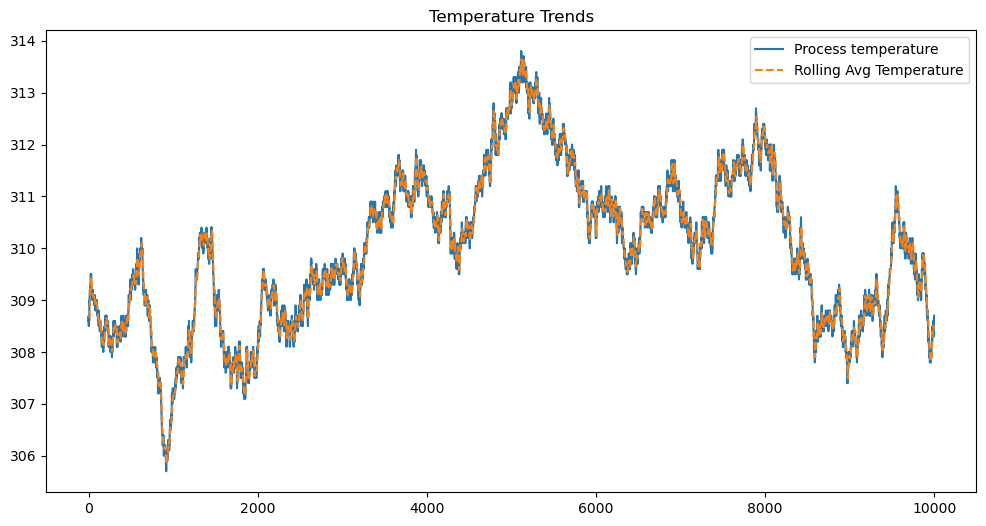

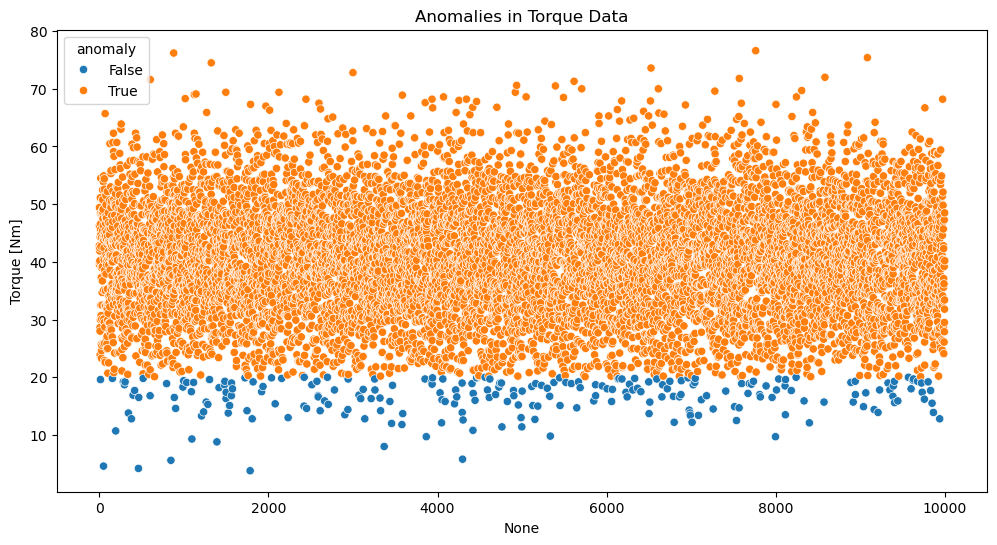

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sensor data trends over time
plt.figure(figsize=(12, 6))
plt.plot(sensor_data['Process temperature [K]'], label='Process temperature')
plt.plot(sensor_data['rolling_avg_temp'], label='Rolling Avg Temperature', linestyle='--')
plt.title('Temperature Trends')
plt.legend()
plt.show()

# Plot anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x=sensor_data.index, y=sensor_data['Torque [Nm]'], hue=sensor_data['anomaly'])
plt.title('Anomalies in Torque Data')
plt.show()


In [19]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume 'features' is your original DataFrame and 'target' is your target variable
X = features  # Replace with your feature DataFrame
y = target    # Replace with your target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (if necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Now you can get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from the original DataFrame
feature_names = features.columns.tolist()

# Check which features were used in training
print("Columns in X_train:", feature_names)

# If features were reduced or selected, update feature_names accordingly
used_feature_names = feature_names[:len(feature_importances)]  # Adjust to match the number of features used

# Now you can plot or use the feature importances as needed


Columns in X_train: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

### visulization of Feature Importance

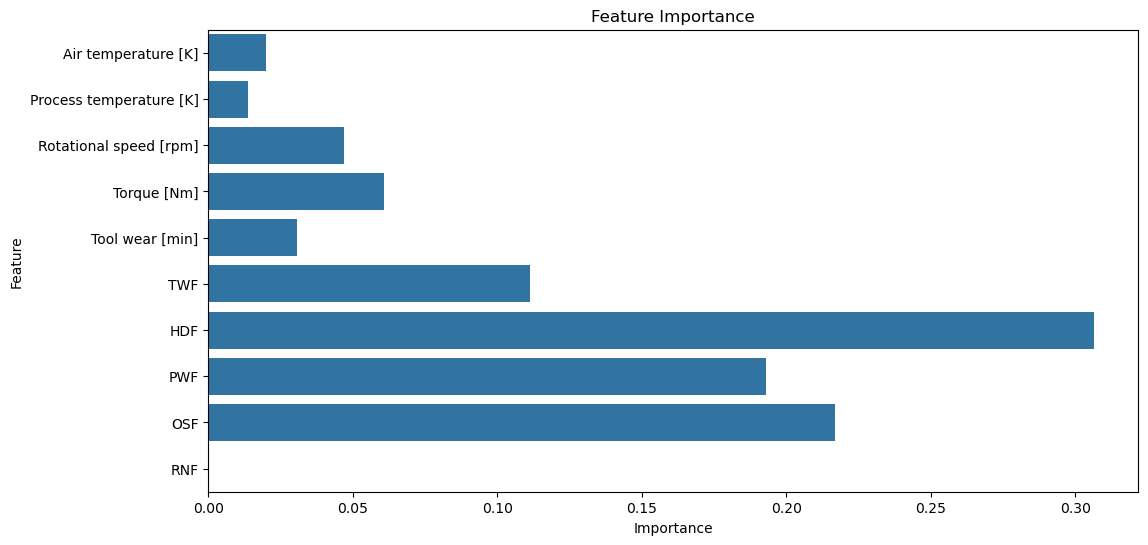

In [33]:
    # Get feature importances from the model
feature_importances = rf_model.feature_importances_
feature_names = features.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
rf_model_optimized = grid_search.best_estimator_

# Predict on the test set using the optimized model
y_pred_optimized = rf_model_optimized.predict(X_test)

# Evaluate the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {accuracy_optimized:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Optimized Accuracy: 1.00


In [30]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model_optimized, X_train, y_train, cv=5, scoring='accuracy')

# Display the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation: {np.std(cv_scores):.2f}")

Cross-Validation Scores: [0.999375 1.       0.998125 1.       0.998125]
Mean Accuracy: 1.00
Standard Deviation: 0.00


### visulization of Optimized Model Confusion Matrix

Optimized Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000



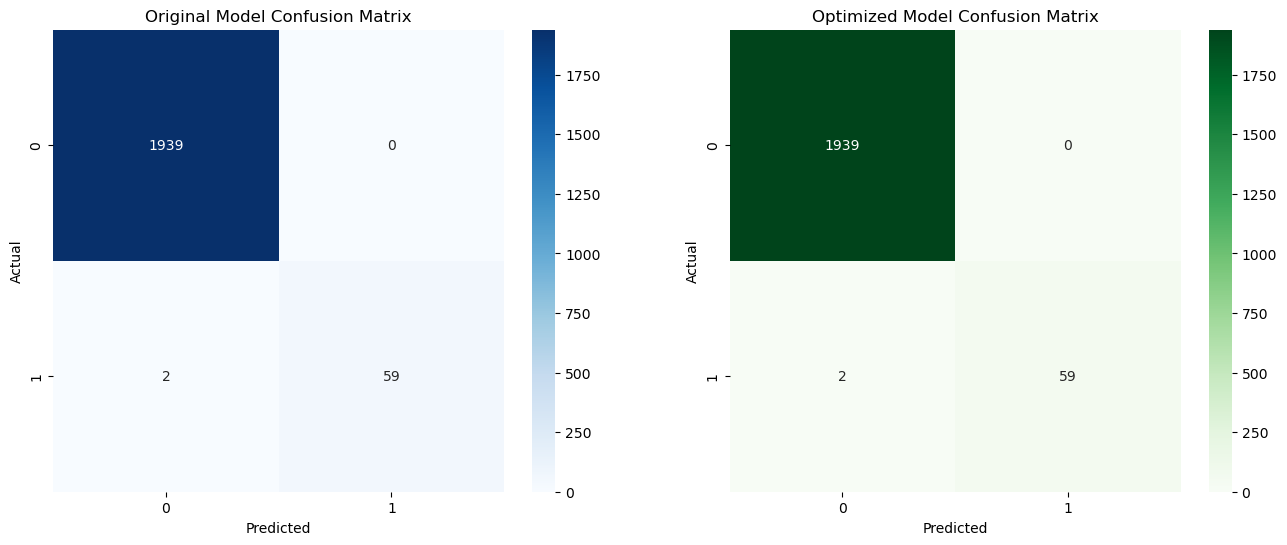

In [26]:
# Print classification report for optimized model
class_report_optimized = classification_report(y_test, y_pred_optimized)
print("Optimized Classification Report:")
print(class_report_optimized)

# Compare the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Original model confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Original Model Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Optimized model confusion matrix
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(conf_matrix_optimized, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Optimized Model Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()